In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import pymc3 as pm
import numpy as np
import pandas as pd
import arviz as az

**我们先拿一个有分类变量的数据集， 这会儿我们看到tip和total_bill是数值连续变量， sex, smoker, day, time, 基本都是分类变量或者离散变量**

In [7]:
plt.style.use('bmh')

In [8]:
tips = sns.load_dataset('tips')

这是一个吃饭给消费的数据集

In [55]:
tips

,total_bill,tip,sex,smoker,day,time,size,day_num
0,16.99,1.01,Female,No,Sun,Dinner,2,0
1,10.34,1.66,Male,No,Sun,Dinner,3,0
2,21.01,3.50,Male,No,Sun,Dinner,3,0
3,23.68,3.31,Male,No,Sun,Dinner,2,0
4,24.59,3.61,Female,No,Sun,Dinner,4,0
...,...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3,1
240,27.18,2.00,Female,Yes,Sat,Dinner,2,1
241,22.67,2.00,Male,Yes,Sat,Dinner,2,1
242,17.82,1.75,Male,No,Sat,Dinner,2,1


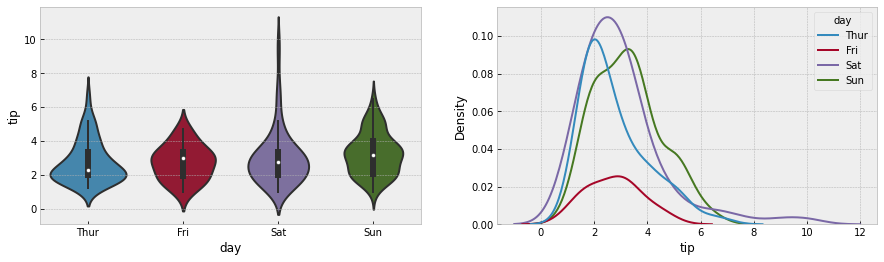

In [9]:
figsize(15,4)
plt.subplot(1,2,1)
sns.violinplot(x = 'day', y = 'tip', data = tips)
plt.subplot(1,2,2)
sns.kdeplot(tips.tip,hue = tips.day)
plt.show()

**我用我肉眼一看，在星期四，星期五。。。感觉没啥太大的区别**

In [10]:
day_num = {d:i for i,d in enumerate(tips.day.unique())}
tips['day_num'] = tips.day.replace(day_num)

In [23]:
idx = tips.day_num.values
n_cats = tips.day.nunique()

with pm.Model() as model:
    means = pm.Normal('means', mu = 2.5, sigma = 5, shape = n_cats)
    stds = pm.HalfNormal('stds', 5, shape = n_cats)
    obs = pm.Normal('obs',mu = means[idx], sigma = stds[idx], observed = tips.tip.values)
    step = pm.Metropolis()
    trace = pm.sample(10000, return_inferencedata=True, step = step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [stds]
>Metropolis: [means]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 27 seconds.
The number of effective samples is smaller than 10% for some parameters.


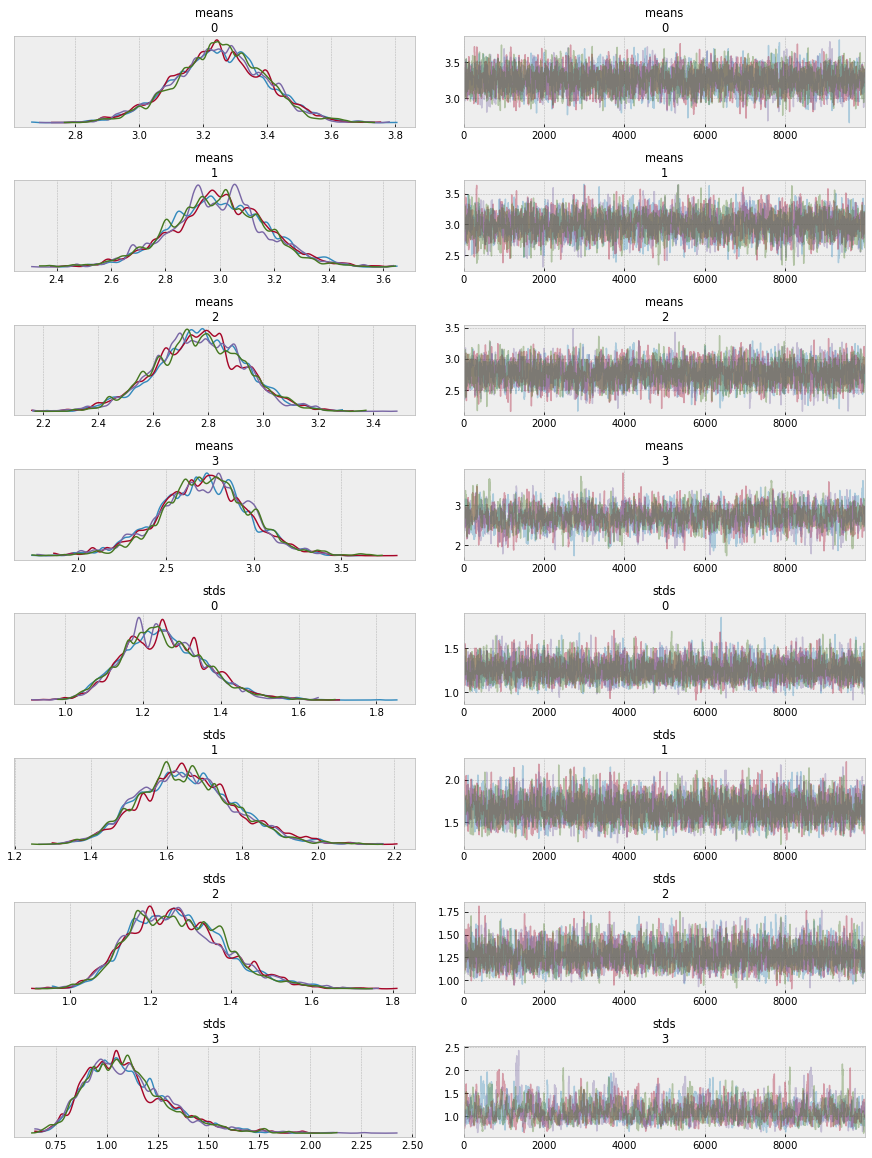

In [25]:
az.plot_trace(trace)
plt.show()

In [26]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
means[0],3.251,0.143,2.978,3.515,0.002,0.002,3746.0,3746.0,3750.0,4628.0,1.0
means[1],2.995,0.179,2.658,3.331,0.003,0.002,2738.0,2738.0,2738.0,3964.0,1.0
means[2],2.770,0.162,2.453,3.065,0.003,0.002,3053.0,3053.0,3051.0,4328.0,1.0
means[3],2.718,0.255,2.241,3.200,0.007,0.005,1468.0,1468.0,1493.0,1925.0,1.0
stds[0],1.254,0.106,1.060,1.447,0.002,0.001,3407.0,3407.0,3410.0,4563.0,1.0
stds[1],1.655,0.129,1.421,1.894,0.002,0.002,3604.0,3589.0,3641.0,5172.0,1.0
stds[2],1.268,0.118,1.063,1.498,0.002,0.002,2819.0,2814.0,2850.0,4211.0,1.0
stds[3],1.100,0.207,0.754,1.491,0.007,0.005,914.0,885.0,976.0,1462.0,1.0


In [27]:
day_num

{'Sun': 0, 'Sat': 1, 'Thur': 2, 'Fri': 3}

我们这儿就可以到，周日付小费的均值是最高的， 周六稍微差一点儿， 周五最差                
但是需要注意的是，周五的样本数量也比较小， 可能周五来餐厅吃饭的人就少吧。                                                         
可以看到周五的标准差也是最小的， 给出很多的消费和很少的小费的人都比较少

In [28]:
tips.groupby('day').count()

,total_bill,tip,sex,smoker,time,size,day_num
day,,,,,,,
Thur,62,62,62,62,62,62,62
Fri,19,19,19,19,19,19,19
Sat,87,87,87,87,87,87,87
Sun,76,76,76,76,76,76,76


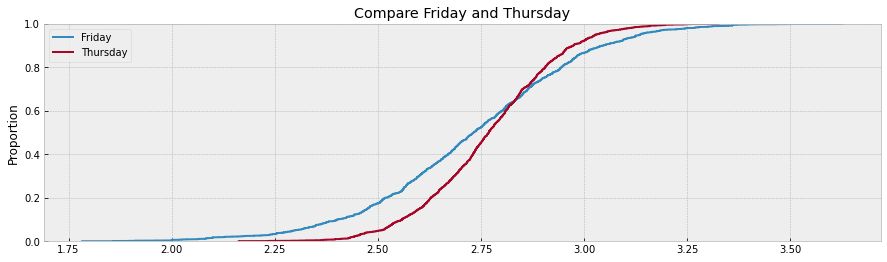

In [41]:
sns.ecdfplot(trace.posterior['means'][:,-2000:,3].values.reshape(-1), label = 'Friday')
sns.ecdfplot(trace.posterior['means'][:,-2000:,2].values.reshape(-1), label = 'Thursday')
plt.legend(loc = 'upper left')
plt.title('Compare Friday and Thursday')
plt.show()

从Posterior来看， 周四比周五来说，极端的人多一些，周五更集中一些

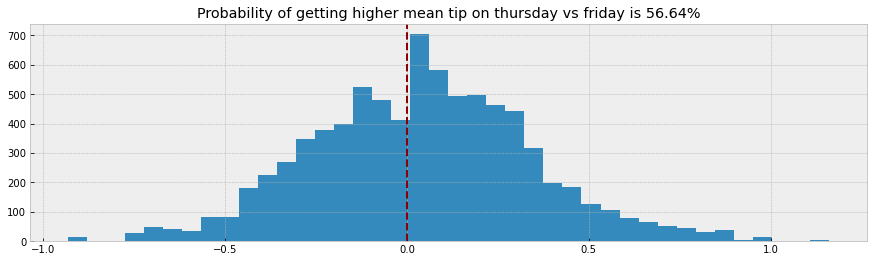

In [54]:
prob = ((trace.posterior['means'][:,-2000:,2] - trace.posterior['means'][:,-2000:,3]).values > 0).reshape(-1).mean()
plt.hist((trace.posterior['means'][:,-2000:,2] - trace.posterior['means'][:,-2000:,3]).values.reshape(-1), bins = 40)
plt.axvline(0, linestyle = '--', color = 'darkred')
plt.title(f'Probability of getting higher mean tip on thursday vs friday is {round(prob*100,2)}%')
plt.show()